# Recreate tables and figures from BashTheBug manuscript

*BashTheBug: a crowd of volunteers reproducibly and accurately measure the minimum inhibitory concentrations of 13 antitubercular drugs from photographs of 96-well broth microdilution plates.*
Fowler PW et al.

The below walks you through recreating the majority of the figures and tables containing in the above scientific manuscript. Where it makes sense, the PDF is written out with the name of the figure e.g. "Figure-2.pdf" and the figures are plotted inline as well. All tables are written out in LaTeX format.

There is a separate file, SCHEMA.PNG, that describes all the input DataFrames and how they are related to one another.

Importantly, if you are running this notebook on mybinder.org, then since the container has limited memory, it cannot load the large `BOOTSTRAPPED_CLASSIFICATIONS` table and hence the `running_using_binder` flag below must be correctly set to True or False 

Simply process each cell in turn! Running all cells takes about 70 seconds on my computer.

--Philip Fowler

In [1]:
## Make sure this flag is correctly set depending on whether you are running using MyBinder or locally ##

running_using_binder=False

## Nothing below requires any user modification!

In [2]:
import copy, numpy, pandas, time, pathlib

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from pandas.api.types import CategoricalDtype

from additional_functions import *

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 150)

plt.rcParams.update({'font.size': 12})

%load_ext autoreload
%autoreload 2

LABORATORY_LOOKUP={'03':'A','04':'B','05':'C','06':'D','07':'E','10':'G','08':'H'}

bashthebug_colours={'red':'#dc2d4c','green':'#9ab51e','blue':'#c8e6e8'}

truth_colors={'TRUTH_SET_1':'#850035',\
              'TRUTH_SET_3':'#d51632' }

# Load data tables

In [3]:
print("Reading PHENOTYPE table...")
PHENOTYPES=pandas.read_csv('tables/PHENOTYPES.csv.gz',dtype={'REPLICATE':object, 'SITEID':object})   
DRUG_LIST=PHENOTYPES.DRUG.unique()
PHENOTYPES.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

print("Reading CLASSIFICATIONS table...")
CLASSIFICATIONS=pandas.read_csv("tables/CLASSIFICATIONS.csv.gz",parse_dates=['CREATED_AT'])
CLASSIFICATIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

print("Reading USERS table...")
USERS=pandas.read_csv("tables/USERS.csv.gz")
USERS.set_index('USER_NAME',inplace=True)

print("Reading SUMMARY tables...")
SUMMARY_DILUTIONS=pandas.read_csv('tables/SUMMARY_DILUTIONS.csv.gz')
SUMMARY_DILUTIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

SUMMARY_DURATIONS=pandas.read_csv('tables/SUMMARY_DURATIONS.csv.gz')
SUMMARY_DURATIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

BASHTHEBUG_RESULTS=pandas.read_csv('tables/BASHTHEBUG_RESULTS.csv.gz')   
BASHTHEBUG_RESULTS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

if not running_using_binder:
    print("Reading BOOTSTRAPPED CLASSIFICATIONS tables...")
    BOOTSTRAPPED_CLASSIFICATIONS=pandas.read_csv('tables/BOOTSTRAPPED_CLASSIFICATIONS.csv.gz')
    BOOTSTRAPPED_CLASSIFICATIONS.set_index(['PLATE','READINGDAY'],inplace=True)

CONSENSUS_SUMMARY=pandas.read_csv('tables/CONSENSUS_SUMMARY.csv.gz')
CONDENSED_SUMMARY=pandas.read_csv('tables/CONDENSED_SUMMARY.csv.gz')
    
    
print("Done!")    

Reading PHENOTYPE table...
Reading CLASSIFICATIONS table...
Reading USERS table...
Reading SUMMARY tables...
Reading BOOTSTRAPPED CLASSIFICATIONS tables...
Done!


# Image dataset

## How many strains/vials were considered?

In [4]:
PHENOTYPES.reset_index(inplace=True)
PHENOTYPES.set_index(['STRAIN','SITEID','REPLICATE'],inplace=True,verify_integrity=False)
print("A total of "+str(len(PHENOTYPES.index.unique()))+" plates were measured")
PHENOTYPES.reset_index(inplace=True)
PHENOTYPES.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

A total of 447 plates were measured


## Table S1: plates by laboratory

In [5]:
df=copy.deepcopy(PHENOTYPES)
df.reset_index(inplace=True)
df.rename(columns={'LABORATORY':'Lab','REPLICATE':'Replicate','EQA_STRAIN':'EQA strain','STRAIN':'Vial'},inplace=True)
TABLE=pandas.crosstab([df['EQA strain'],df['Vial'],df['Replicate']],df['Lab'])
TABLE.replace(70,"Y",inplace=True)
TABLE.replace(98,"Y",inplace=True)
TABLE.replace(112,"Y",inplace=True)
TABLE.replace(0,"-",inplace=True)
print(TABLE.to_latex(longtable=True,\
                     caption='List of strains and their repeats tested by laboratory.',\
                     label='table:S1',\
                     column_format='rrr|cccccccc').rstrip())

\begin{longtable}{rrr|cccccccc}
\caption{List of strains and their repeats tested by laboratory.}
\label{table:S1}\\
\toprule
      &        & Lab &  A &  B &  C &  D &  E &  G &  H \\
EQA strain & Vial & Replicate &    &    &    &    &    &    &    \\
\midrule
\endfirsthead
\caption[]{List of strains and their repeats tested by laboratory.} \\
\toprule
      &        & Lab &  A &  B &  C &  D &  E &  G &  H \\
EQA strain & Vial & Replicate &    &    &    &    &    &    &    \\
\midrule
\endhead
\midrule
\multicolumn{10}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
WHO-1 & CRY-19 & 0001 &  Y &  Y &  Y &  Y &  Y &  Y &  Y \\
      &        & 0002 &  Y &  Y &  Y &  Y &  Y &  Y &  Y \\
      & CRY-7 & 0001 &  Y &  Y &  Y &  Y &  - &  Y &  Y \\
      &        & 0002 &  Y &  Y &  Y &  Y &  - &  Y &  Y \\
WHO-10 & CRY-18 & 0001 &  Y &  Y &  Y &  - &  - &  Y &  Y \\
      &        & 0002 &  Y &  Y &  Y &  - &  - &  Y &  Y \\
WHO-11 & CRY-16 & 0001 &  Y &  Y &  Y

# Project launch and progress

## The first week

Project launched on 8 April 2017 having beta-tested on 22 March 2017

In [6]:
first_week=CLASSIFICATIONS.loc[CLASSIFICATIONS.CREATED_AT<'2017-04-13']
first_week.CREATED_AT.sort_values()

PLATE             READINGDAY  DRUG
H37rV-08-0009-1   21.0        DLM    2017-03-21 12:41:25
CRY-27-08-0001-1  21.0        INH    2017-03-21 12:41:32
CRY-24-08-0002-1  14.0        CFZ    2017-03-21 12:41:40
CRY-26-08-0002-1  21.0        LEV    2017-03-21 12:41:55
CRY-21-08-0002-1  21.0        INH    2017-03-21 12:41:59
                                             ...        
CRY-30-08-0002-1  14.0        MXF    2017-04-12 23:59:21
CRY-1-08-0002-1   14.0        MXF    2017-04-12 23:59:28
CRY-3-08-0002-1   14.0        LZD    2017-04-12 23:59:43
                              RIF    2017-04-12 23:59:50
CRY-8-08-0001-1   14.0        DLM    2017-04-12 23:59:55
Name: CREATED_AT, Length: 74949, dtype: datetime64[ns]

In [7]:
print("The beta testers did "+str(len(first_week.loc[first_week.CREATED_AT<'2017-03-23']))+" classifications")

The beta testers did 14162 classifications


In [8]:
print("By the end of the first week a total of "+str(len(first_week))+" classifications had been done")

By the end of the first week a total of 74949 classifications had been done


In [9]:
print("..by "+str(len(first_week.USER_NAME.unique()))+ " users of which "+str(len(first_week.loc[~first_week.ANONYMOUS].USER_NAME.unique()))+ " had usernames ")

..by 2029 users of which 1259 had usernames 


## First hundred days (Spiers2019)

In [10]:
FIRST_HUNDRED_DAYS=CLASSIFICATIONS.loc[(CLASSIFICATIONS.CREATED_AT>'2017-04-07') & (CLASSIFICATIONS.CREATED_AT<'2019-07-16')]
len(FIRST_HUNDRED_DAYS)

381964

In [11]:
len(FIRST_HUNDRED_DAYS.USER_NAME.unique()), len(FIRST_HUNDRED_DAYS.loc[~FIRST_HUNDRED_DAYS.ANONYMOUS].USER_NAME.unique())

(6237, 3733)

## Figure 2 - Time series

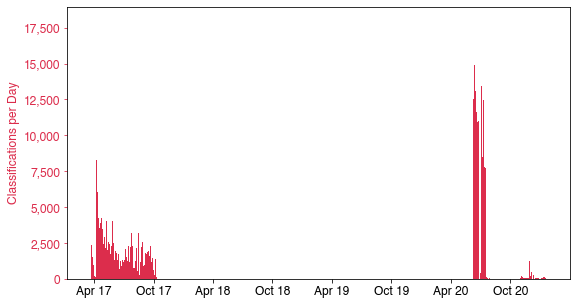

In [12]:
df=copy.deepcopy(CLASSIFICATIONS[['CREATED_AT']])

colour='#dc2d4c'

# set it as the index and then re-sample
df.set_index(df.CREATED_AT,inplace=True)

resampled_data=df.resample('D').count()
bar_width=1.01

number_of_months = int((df.index.max()-df.index.min())/numpy.timedelta64(1, 'M'))

resampled_data.columns=['number']

resampled_data['total']=resampled_data.cumsum()

fig = plt.figure(figsize=(9, 5))

axes1 = plt.gca()

axes1.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

axes1.set_ylabel("Classifications per Day",color=colour)
axes1.tick_params('y', colors=colour)
axes1.bar(resampled_data.index,resampled_data.number,width=bar_width,align='center',lw=0,fc=colour,zorder=10)
axes1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
axes1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes1.set_ylim(bottom=0)

fig.savefig('pdf/Figure-2-classifications-time-daily.pdf',transparent=True)

In [13]:
first_set=CLASSIFICATIONS.loc[CLASSIFICATIONS.CREATED_AT<'2019-01-01'].CREATED_AT
first_set.sort_values()

PLATE             READINGDAY  DRUG
H37rV-08-0009-1   21.0        DLM    2017-03-21 12:41:25
CRY-27-08-0001-1  21.0        INH    2017-03-21 12:41:32
CRY-24-08-0002-1  14.0        CFZ    2017-03-21 12:41:40
CRY-26-08-0002-1  21.0        LEV    2017-03-21 12:41:55
CRY-21-08-0002-1  21.0        INH    2017-03-21 12:41:59
                                             ...        
CRY-14-08-0001-1  21.0        EMB    2017-10-11 18:50:07
CRY-16-03-0002-1  14.0        EMB    2017-10-11 18:50:19
CRY-30-04-0001-1  21.0        EMB    2017-10-11 18:56:17
CRY-9-07-0002-1   21.0        EMB    2017-10-11 18:56:24
H37rV-03-0002-2   21.0        BDQ    2017-12-19 17:16:45
Name: CREATED_AT, Length: 416782, dtype: datetime64[ns]

In [14]:
second_set=CLASSIFICATIONS.loc[CLASSIFICATIONS.CREATED_AT>'2019-01-01'].CREATED_AT
second_set.sort_values()

PLATE             READINGDAY  DRUG
CRY-13-10-0001-1  10.0        MXF    2020-06-08 18:17:54
H37rV-04-0005-1   10.0        MXF    2020-06-08 18:18:41
H37rV-05-0009-2   7.0         RFB    2020-06-08 18:25:27
CRY-21-04-0002-2  21.0        AMI    2020-06-08 18:25:52
CRY-3-07-0001-2   10.0        AMI    2020-06-08 18:25:59
                                             ...        
CRY-1-08-0002-1   14.0        CFZ    2021-01-19 10:34:26
CRY-25-08-0001-1  14.0        MXF    2021-01-19 10:34:33
H37rV-08-0001-1   14.0        RIF    2021-01-19 10:34:39
CRY-13-08-0002-1  14.0        MXF    2021-01-20 07:20:23
CRY-29-08-0002-1  14.0        LEV    2021-01-20 07:21:19
Name: CREATED_AT, Length: 371420, dtype: datetime64[ns]

## General description

In [15]:
print(str(len(USERS))+" volunteers participated doing a total of "+str(len(CLASSIFICATIONS))+" classifications")

print("This is a mean of %.1f each" % (len(CLASSIFICATIONS)/len(USERS)))

print("but this hides a large amount of variation in the number of classifications done by individual volunteers")

print("So, "+str(len(USERS.loc[USERS.CLASSIFICATIONS==1]))+" volunteers only did 1 classification and "+str(len(USERS.loc[USERS.CLASSIFICATIONS<=10]))+" did ten or fewer")

9372 volunteers participated doing a total of 788202 classifications
This is a mean of 84.1 each
but this hides a large amount of variation in the number of classifications done by individual volunteers
So, 1115 volunteers only did 1 classification and 4299 did ten or fewer


In [16]:
print("By contrast, the ten volunteers who participated the most did %i classifications between them which is %.1f %% of the total " % (USERS[-10:].CLASSIFICATIONS.sum(),100*USERS[-10:].CLASSIFICATIONS.sum()/len(CLASSIFICATIONS)))

By contrast, the ten volunteers who participated the most did 103569 classifications between them which is 13.1 % of the total 


## Figure 2 - Gini coefficient

In [17]:
area_under_curve=(USERS.PROPORTION_TOTAL_CLASSIFICATIONS.sum())/len(USERS)
gini_coefficient=1-(2*area_under_curve)
print("Gini coefficient is %.3f" % (gini_coefficient))

Gini coefficient is 0.850


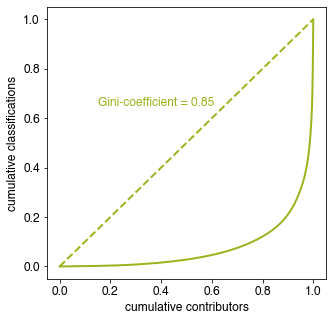

In [18]:
# use a square figure
fig = plt.figure(figsize=(5, 5))
axes1 = plt.gca()

axes1.plot(USERS.PROPORTION_USER_BASE,USERS.PROPORTION_TOTAL_CLASSIFICATIONS,color="#9ab51e",linewidth=2)
axes1.plot([0,1],[0,1],color="#9ab51e",linestyle='dashed',linewidth=2)
axes1.text(0.15,0.65,"Gini-coefficient = %.2f" % gini_coefficient,color="#9ab51e")
axes1.set_xlabel('cumulative contributors')
axes1.set_ylabel('cumulative classifications')
fig.savefig("pdf/Figure-2-gini.pdf",transparent=True)

## Figure S3 - classifications per image

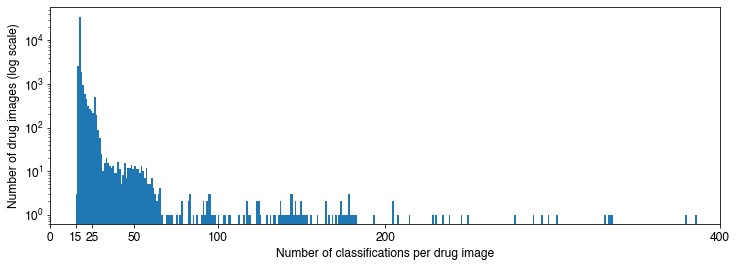

In [19]:
graph,axes=plt.subplots(1,1,figsize=(12,4))
a=axes.hist(SUMMARY_DILUTIONS.COUNT,bins=numpy.arange(0,400,1),density=False,cumulative=False)  
axes.set_yscale('log')
axes.set_xticks([0,15,25,50,100,200,400]) 
axes.set_xlim([0,400]) 
axes.set_xlabel('Number of classifications per drug image')
axes.set_ylabel('Number of drug images (log scale)')
graph.savefig('pdf/Figure-S3.pdf')

## Task duration

## Figure 2, S4 task duration by reading day

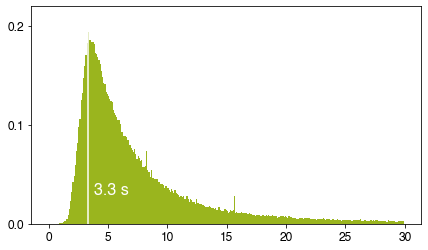

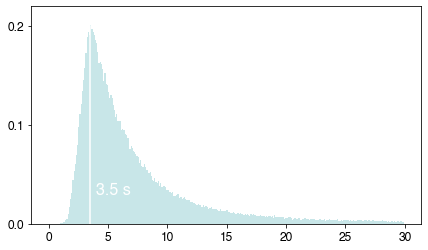

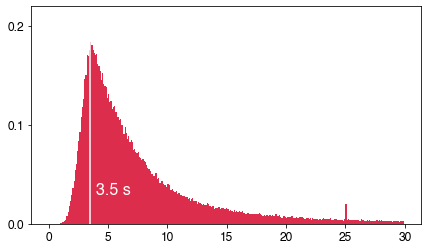

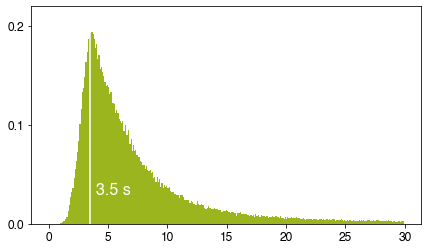

In [20]:
CLASSIFICATIONS.reset_index(inplace=True)

colour_lookup={ 14:'#dc2d4c',\
                 7:'#9ab51e',\
                10:'#c8e6e8',\
                21:'#9ab51e' }


for reading_day in [7,10,14,21]:

    path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / 'duration'
    path.mkdir(parents=True,exist_ok=True)
    
    df=copy.deepcopy(CLASSIFICATIONS.loc[CLASSIFICATIONS.READINGDAY==reading_day])
    
    graph,axes=plt.subplots(1,1,figsize=(7,4))
    a=axes.hist(df.TASK_DURATION,bins=numpy.arange(0,30,0.1),density=True,color=colour_lookup[reading_day])    
    axes.set_ylim([0,0.22])
    axes.set_yticks([0,0.1,0.2])
    
    df['TASK_DURATION_BIN']=pandas.cut(df.TASK_DURATION,bins=numpy.arange(0,30,0.1),labels=False,retbins=False)
    duration_mode=df.TASK_DURATION_BIN.mode()/10
    if len(duration_mode)>1:
        duration_mode=duration_mode[0]
    axes.plot([duration_mode,duration_mode],[0,0.2],color='white')
    axes.text(duration_mode+0.5,0.03,str(float(duration_mode))+" s",color='white',weight='bold',fontsize=16)

    filename='hist-task-duration.pdf'
    
    graph.savefig(path / filename)
    
CLASSIFICATIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

## Figure S5 - Task duration by drug after 14 days of incubation

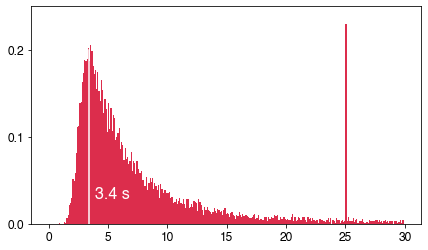

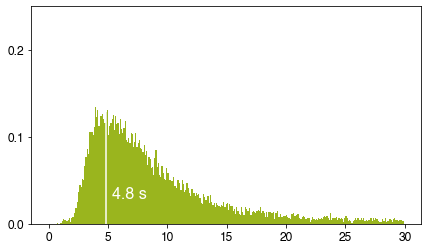

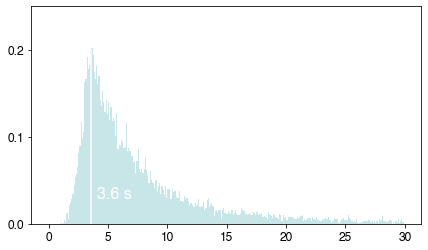

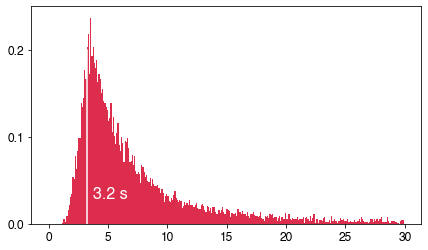

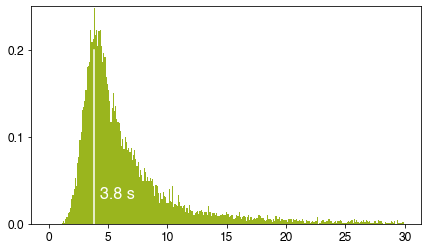

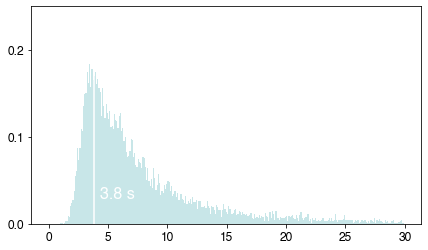

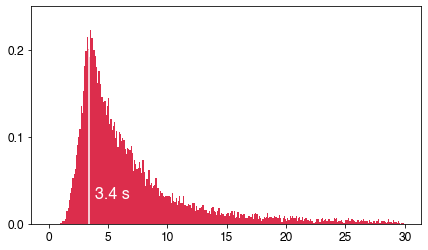

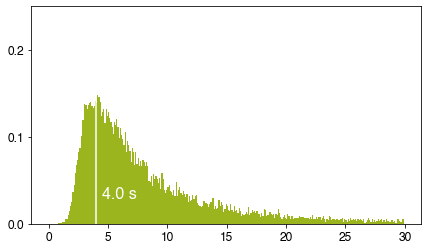

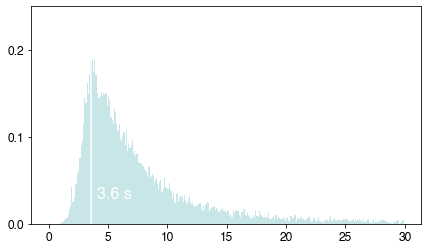

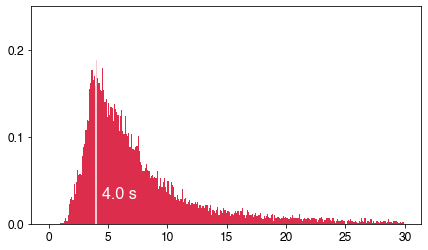

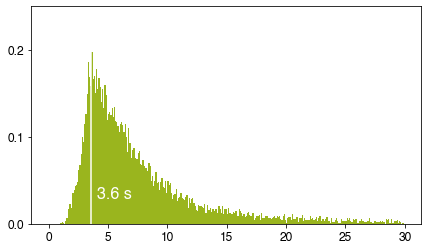

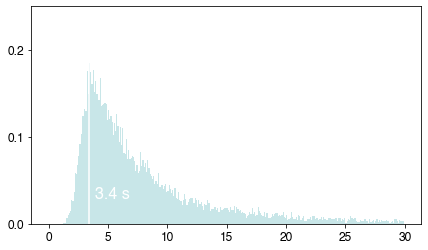

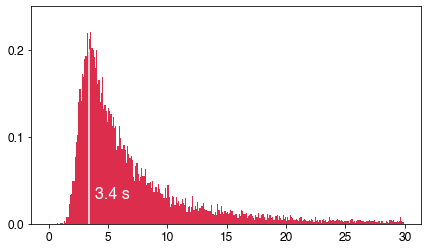

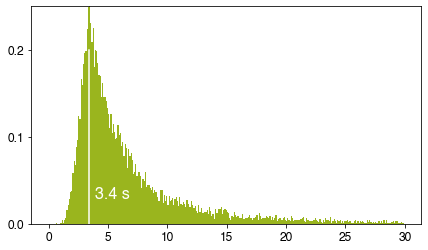

In [21]:
CLASSIFICATIONS.reset_index(inplace=True)

colours=list(bashthebug_colours.values())

counter=0

path=pathlib.Path.cwd() / 'pdf' / '14' / 'duration'
path.mkdir(parents=True,exist_ok=True)

for drug in DRUG_LIST:
    
    if drug=='POS':
        continue 
        
    df=copy.deepcopy(CLASSIFICATIONS.loc[(CLASSIFICATIONS.READINGDAY==14) & (CLASSIFICATIONS.DRUG==drug)])
    
    graph,axes=plt.subplots(1,1,figsize=(7,4))
    a=axes.hist(df.TASK_DURATION,bins=numpy.arange(0,30,0.1),density=True,color=colours[counter % 3])    
    axes.set_ylim([0,0.25])
    axes.set_yticks([0,0.1,0.2])
    
    df['TASK_DURATION_BIN']=pandas.cut(df.TASK_DURATION,bins=numpy.arange(0,30,0.2),labels=False,retbins=False)
    duration_mode=df.TASK_DURATION_BIN.mode()/5
    if len(duration_mode)>1:
        duration_mode=duration_mode[0]
    axes.plot([duration_mode,duration_mode],[0,0.2],color='white')
    axes.text(duration_mode+0.5,0.03,str(float(duration_mode))+" s",color='white',weight='bold',fontsize=16)
    counter+=1

    filename='hist-task-duration-'+drug+'.pdf'
    
    graph.savefig(path / filename)
    
CLASSIFICATIONS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

# Table S2

In [22]:
a=pandas.cut(SUMMARY_DILUTIONS.COUNT,\
               bins=[0,14,15,16,17,18,19,20,22,25,30,40,50,75,100,150,200,300,500],\
               labels=["n $\le$ 14","15","16","17","18","19","20","21 or 22","23, 24 or 25","25 $<$ n $<$ 29","30 $<$ n $<$ 39","40 $<$ n $<$ 49",\
                       "50 $<$ n $<$ 74","75 $<$ n $<$ 99","100 $<$ n $<$ 149","150 $<$ n $<$ 199","200 $<$ n $<$ 299","300 $<$ n $<$ 499"],\
            right=True).value_counts().sort_index()

TABLE=a.to_frame()
TABLE.reset_index(inplace=True)
TABLE.rename(columns={'index':'Classifications performed by volunteers','COUNT':'Number of drug images'},inplace=True)

total=SUMMARY_DILUTIONS.COUNT.count()

def calc_prop(row):
    return("%.1f" % (100*row['Number of drug images']/total))

TABLE['Proportion of drug images']=TABLE.apply(calc_prop,axis=1)

print("\\begin{table}\n\\begin{center}")
print(TABLE.to_latex(index=False,escape=False).rstrip())
print("\\caption[The number of classifications performed for each drug image]{\\label{table:S2} The number of classifications performed for each drug image. The retirement limit on the Zooniverse platform was set to 17, however, a subset of images recieved many more classifications. }")
print("\\end{center}\n\\end{table}\n")

\begin{table}
\begin{center}
\begin{tabular}{lrl}
\toprule
Classifications performed by volunteers &  Number of drug images & Proportion of drug images \\
\midrule
                             n $\le$ 14 &                      0 &                       0.0 \\
                                     15 &                      3 &                       0.0 \\
                                     16 &                   2659 &                       6.1 \\
                                     17 &                  34843 &                      79.8 \\
                                     18 &                   1841 &                       4.2 \\
                                     19 &                    924 &                       2.1 \\
                                     20 &                    601 &                       1.4 \\
                               21 or 22 &                    760 &                       1.7 \\
                           23, 24 or 25 &                    720 &  

In [23]:
len(SUMMARY_DILUTIONS[SUMMARY_DILUTIONS.COUNT>=34]),len(SUMMARY_DILUTIONS[SUMMARY_DILUTIONS.COUNT>=100]) 

(421, 89)

## Figure S7 - growth histograms

TRUTH_SET_1 mean growth is 30.6 % 
MEDIUM    0.783902
HIGH      0.140454
LOW       0.075644
Name: GROWTH, dtype: float64
TRUTH_SET_3 mean growth is 30.4 % 
MEDIUM    0.779180
HIGH      0.139956
LOW       0.080864
Name: GROWTH, dtype: float64


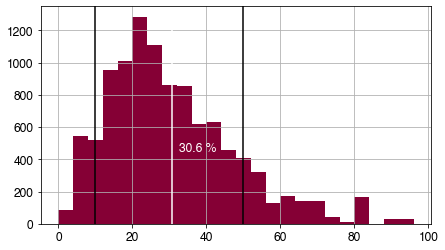

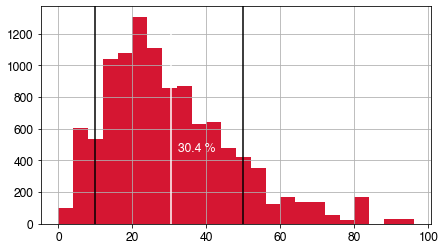

In [24]:
if running_using_binder:

    print("Sorry but the table required to plot this figure uses too much memory for mybinder; please clone the repository and run the juypter-notebook locally")

else:

    BOOTSTRAPPED_CLASSIFICATIONS.reset_index(inplace=True)

    for i in truth_colors.keys():

        df=copy.deepcopy(BOOTSTRAPPED_CLASSIFICATIONS.loc[(BOOTSTRAPPED_CLASSIFICATIONS[i]!=0) &\
                              (BOOTSTRAPPED_CLASSIFICATIONS.READINGDAY==14) & \
                              (BOOTSTRAPPED_CLASSIFICATIONS.BOOTSTRAP_RUN==0) &\
                              (BOOTSTRAPPED_CLASSIFICATIONS.N_CLASSIFICATIONS==3)] )

        fig,axes=plt.subplots(1,1,figsize=(7,4))
        axes=df.IM_POS_AVERAGE.hist(bins=numpy.arange(0,100,4),color=truth_colors[i])
        mean_growth=df.IM_POS_AVERAGE.mean()
        max_y=numpy.max(axes.get_ylim())
        axes.plot((mean_growth,mean_growth),(0,max_y),color='white')
        axes.text(mean_growth+2,max_y/3,'%.1f %%' % (mean_growth),color='white')
        axes.plot((10,10),(0,max_y),color='black')
        axes.plot((50,50),(0,max_y),color='black')
        axes.set_ylim([0,max_y])
        path=pathlib.Path.cwd() / 'pdf' / '14' / 'growth'
        filename='hist-14-'+i.lower()+'-growth.pdf'
        path.mkdir(parents=True,exist_ok=True)

        fig.savefig(path / filename,bbox_inches=0)

        if i=='TRUTH_SET_2':
            plt.close()
        else:
            print("%s mean growth is %.1f %% " % (i,df.IM_POS_AVERAGE.mean()))
            print(df.GROWTH.value_counts(normalize=True))

    BOOTSTRAPPED_CLASSIFICATIONS.set_index(['PLATE','READINGDAY'],inplace=True)


## Figure 3, S8, S9 - raw heatmaps and dilution distributions

Note that since the code below uses two plotting functions provided, those graphs are written to disc rather than displayed inline.

truth_set_1 after  7 days contains  12502 measurements and 160102 classifications


/var/folders/np/2z_qny9911n2mqth2n63j9y80009px/T/ipykernel_22513/2425101182.py:74: RuntimeWarning: invalid value encountered in long_scalars
  agreement_with_expert=[100*grid[i][i]/numpy.sum(grid[i,0:]) for i in range(0,10)]


truth_set_1 after 10 days contains  12474 measurements and 177315 classifications
truth_set_1 after 14 days contains  12488 measurements and 206353 classifications
truth_set_1 after 21 days contains  12474 measurements and 186624 classifications
truth_set_3 after  7 days contains   5598 measurements and  80197 classifications
truth_set_3 after 10 days contains   5662 measurements and  85912 classifications


/var/folders/np/2z_qny9911n2mqth2n63j9y80009px/T/ipykernel_22513/2425101182.py:74: RuntimeWarning: invalid value encountered in long_scalars
  agreement_with_expert=[100*grid[i][i]/numpy.sum(grid[i,0:]) for i in range(0,10)]


truth_set_3 after 14 days contains   6205 measurements and 112163 classifications
truth_set_3 after 21 days contains   6394 measurements and 106144 classifications


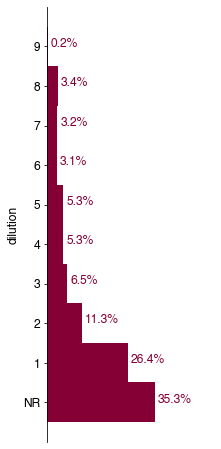

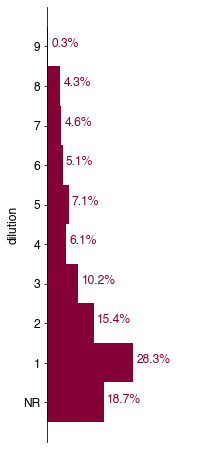

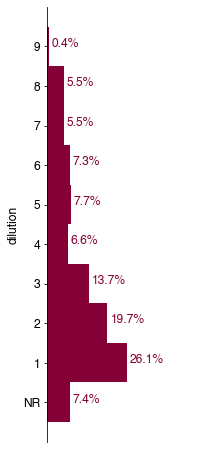

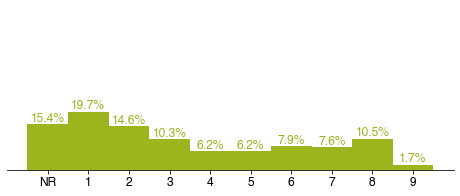

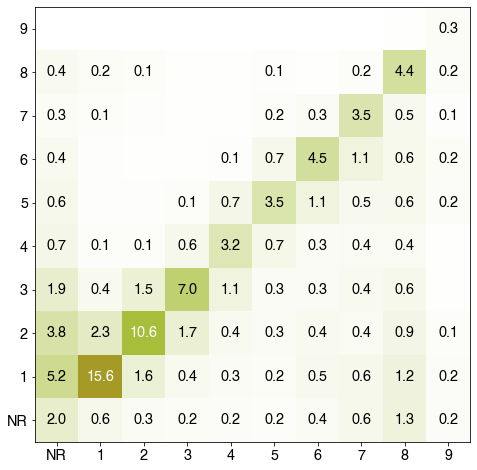

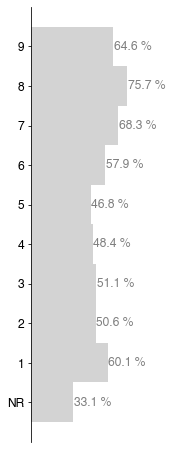

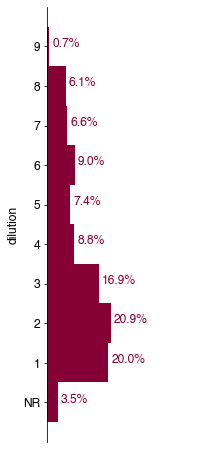

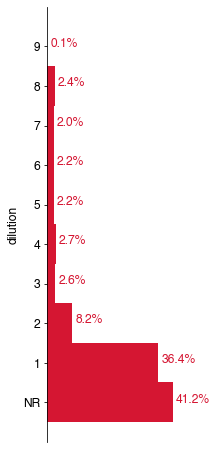

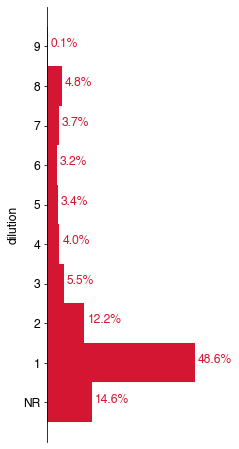

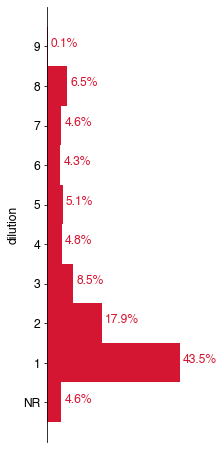

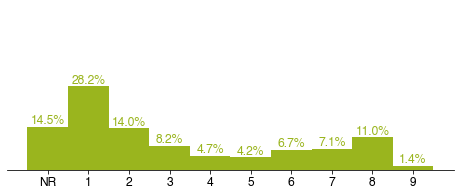

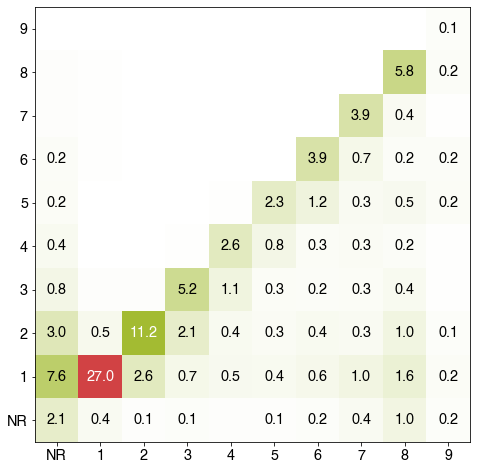

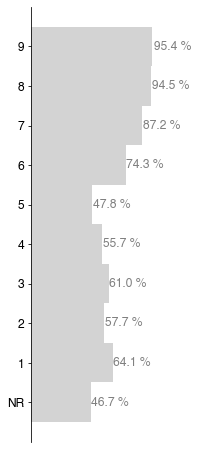

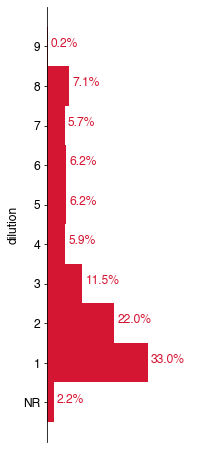

In [25]:
PHENOTYPES.reset_index(inplace=True)
BASHTHEBUG_RESULTS.reset_index(inplace=True)

table=[]
pullout_images={}

categorical_dilutions = CategoricalDtype(categories=range(10), ordered=True)

BASHTHEBUG_RESULTS['BASHTHEBUG_DILUTION']=BASHTHEBUG_RESULTS['BASHTHEBUG_DILUTION'].astype(categorical_dilutions)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_width()
        axes.text(1.01*height, rect.get_y() + rect.get_height()/2.,
                '%.1f %%' % height,
                ha='left', va='center',color='grey')

for truth_set in ['TRUTH_SET_1','TRUTH_SET_3']:

    PHENOTYPES[truth_set]=PHENOTYPES[truth_set].astype(categorical_dilutions)
    BASHTHEBUG_RESULTS[truth_set]=BASHTHEBUG_RESULTS[truth_set].astype(categorical_dilutions)
    
    for reading_day in [7,10,14,21]:
       
        # subset down to the only those in the truth set
        df=PHENOTYPES.loc[(PHENOTYPES[truth_set].notna()) & (PHENOTYPES.READINGDAY==reading_day)]    

        # plot the distribution       
        plot_classifications_hist(df[truth_set],
                                  reading_day,
                                  'accuracy', 
                                  truth_set.lower(),
                                  'all',
                                  'all',
                                  'dilution-1',
                                  truth_colors[truth_set])    

        # now join the raw classifications so we can look at classification variability
        df2=BASHTHEBUG_RESULTS.loc[(BASHTHEBUG_RESULTS[truth_set].notna()) & (BASHTHEBUG_RESULTS.READINGDAY==reading_day) & (BASHTHEBUG_RESULTS.DRUG!='PAS')]    

        if reading_day==14:
            plot_classifications_hist(df2['BASHTHEBUG_DILUTION'],
                              reading_day,
                              'accuracy',        
                              truth_set.lower(),
                              'all',
                              'all',
                              'bashthebug-1',
                              bashthebug_colours['green'],orientation='horizontal')    
        
        print(truth_set.lower()+" after %2i days contains %6i measurements and %6i classifications" % (reading_day,len(df),len(df2)))
        
        row=[truth_set,reading_day,len(df),len(df2)]

        # plot the heatmap
        if reading_day==14:
            grid=pandas.crosstab(df2[truth_set],df2['BASHTHEBUG_DILUTION'],normalize=True,dropna=False)
            plot_heatmap(grid,\
                         reading_day,
                         'accuracy',
                         truth_set.lower(),
                         'all',
                         'all',    
                         None,
                         'all',
                         vmax=30)

        grid=pandas.crosstab(df2[truth_set],df2['BASHTHEBUG_DILUTION'],normalize=False,dropna=False)
        grid=numpy.array(grid)
        assert grid.shape==(10,10), 'grid has shape '+str(grid.shape)
        agreement_with_expert=[100*grid[i][i]/numpy.sum(grid[i,0:]) for i in range(0,10)]
            
        if reading_day==14:
            fig,axes=plt.subplots(1,1,figsize=(2.5,8))
            y=numpy.arange(0,10)
            height=1
            rects1=axes.barh(y,numpy.nan_to_num(agreement_with_expert),color='lightgrey',height=height)
            axes.set_yticks(y)
            y_range=axes.get_ylim()
            axes.set_ylim(y_range)
            axes.set_yticklabels(['NR']+[i for i in range(1,10)])
            axes.set_xlim((0,110))
            axes.spines['right'].set_visible(False)
            axes.spines['top'].set_visible(False)
            axes.spines['bottom'].set_visible(False)
            axes.set_xticks([])
            autolabel(rects1)

            path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / 'accuracy' / truth_set.lower() / 'all' / 'all'
            path.mkdir(parents=True,exist_ok=True)

            filename='bar-'+str(reading_day)+'-accuracy-'+truth_set.lower()+'-all-expert-agreement.pdf'
            fig.savefig(path / filename)
    
       
        # update the row and add to the table
        row+=calculate_grid_metrics(grid)
        table.append(row)

        
RAW_SUMMARY=pandas.DataFrame(table,columns=['TRUTH_SET','READINGDAY','N_MEASUREMENTS','N_CLASSIFICATIONS',\
                                        'N','DIAGONAL','UPPER_DIAGONAL','LOWER_DIAGONAL','UPPER_TRIANGLE',\
                                        'LOWER_TRIANGLE','BOTH_NR','TRUTH_OK_METHOD_NR',\
                                        'TRUTH_NR_METHOD_OK','INNER_SQUARE'])

RAW_SUMMARY['ESSENTIAL_AGREEMENT']=100*(RAW_SUMMARY['DIAGONAL']+\
                                              RAW_SUMMARY['UPPER_DIAGONAL']+\
                                              RAW_SUMMARY['LOWER_DIAGONAL'])/RAW_SUMMARY['INNER_SQUARE']

RAW_SUMMARY['EXACT_AGREEMENT']=100*RAW_SUMMARY['DIAGONAL']/RAW_SUMMARY['INNER_SQUARE']        

PHENOTYPES.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)
BASHTHEBUG_RESULTS.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

## Table S3 - truth datasets

In [26]:
table=copy.deepcopy(RAW_SUMMARY)
table=table[['READINGDAY','TRUTH_SET','N_MEASUREMENTS', 'N_CLASSIFICATIONS','ESSENTIAL_AGREEMENT','EXACT_AGREEMENT']]
table.replace({'TRUTH_SET':{'TRUTH_SET_1':'Expert',\
                            'TRUTH_SET_2':'Expert+mirrored-box',\
                            'TRUTH_SET_3':'Expert+AMyGDA'}},inplace=True)
table['TRUTH_SET']=pandas.Categorical(table['TRUTH_SET'],['Expert+AMyGDA','Expert','Expert+mirrored-box'])
table=table.loc[table.TRUTH_SET!='Expert+mirrored-box']
table.sort_values(by=['READINGDAY','TRUTH_SET'],inplace=True)
table.set_index(['READINGDAY','TRUTH_SET'],inplace=True)
table.index.names=(['Reading day','Reference dataset'])

print("\\begin{table}\n\\begin{center}")
print(table.to_latex(float_format='%.1f %%',\
                     column_format='c|crrrr',\
               escape=True,\
               index=True,\
               multirow=True,\
                     multicolumn=True,\
               header=['Measurements','Classifications','Essential agreement','Exact agreement']).rstrip())
print("\\caption[Individual volunteers only agree with the Expert+AMyGDA reference dataset in 60-70\% of drug images.]{\\label{table:S3} Individual volunteers only agree with the Expert+AMyGDA reference dataset in 60-70\% of drug images. The exact and essential agreement between individual volunteers and the reference Expert+AMyGDA dataset improves with the length of incubation. The Expert dataset is shown for comparision. }")
print("\\end{center}\n\\end{table}\n")

\begin{table}
\begin{center}
\begin{tabular}{c|crrrr}
\toprule
   &        & Measurements & Classifications & Essential agreement & Exact agreement \\
Reading day & Reference dataset &              &                 &                     &                 \\
\midrule
\multirow{2}{*}{7} & Expert+AMyGDA &         5598 &           80197 &              85.2 \% &          68.7 \% \\
   & Expert &        12502 &          160102 &              81.7 \% &          59.9 \% \\
\cline{1-6}
\multirow{2}{*}{10} & Expert+AMyGDA &         5662 &           85912 &              86.1 \% &          73.1 \% \\
   & Expert &        12474 &          177315 &              82.7 \% &          63.2 \% \\
\cline{1-6}
\multirow{2}{*}{14} & Expert+AMyGDA &         6205 &          112163 &              86.4 \% &          74.6 \% \\
   & Expert &        12488 &          206353 &              83.3 \% &          65.3 \% \\
\cline{1-6}
\multirow{2}{*}{21} & Expert+AMyGDA &         6394 &          106144 &              8

## Table S4 - Expert and AMyGDA agreement by dilution

In [27]:
PHENOTYPES.reset_index(inplace=True)

PHENOTYPES['IN_TRUTH_SET_3']=(PHENOTYPES.TRUTH_SET_3>=0)
table=copy.deepcopy(PHENOTYPES[['VZ','IN_TRUTH_SET_3']].groupby('VZ').agg([numpy.mean,stats.sem]))
table.columns=table.columns.droplevel()

def return_formatted_values(row):
    return("%.1f $\pm$ %.1f %%"% (100*row['mean'],100*row['sem']))

table['Agreement']=table.apply(return_formatted_values,axis=1)
table.reset_index(inplace=True)
table.rename(columns={'VZ':'Dilution'},inplace=True)
table.Dilution=table.Dilution.astype(int)
table.replace({'Dilution':{0:'NR'}},inplace=True)
table=table[['Dilution','Agreement']]

print("\\begin{table}\n\\begin{center}")
print(table.to_latex(float_format='%.1f %',\
                     column_format='r|r',\
               escape=False,\
               index=False).rstrip())
print("\\caption[The Expert and AMyGDA MICs are more likely to concur at smaller dilutions.]{\\label{table:S4} The Expert and AMyGDA MICs are more likely to concur at smaller dilutions. The standard error of the mean is given.}")
print("\\end{center}\n\\end{table}\n")

PHENOTYPES.set_index(['PLATE','READINGDAY','DRUG'],inplace=True)

\begin{table}
\begin{center}
\begin{tabular}{r|r}
\toprule
Dilution &        Agreement \\
\midrule
      NR & 43.9 $\pm$ 0.6 % \\
       1 & 76.3 $\pm$ 0.4 % \\
       2 & 43.5 $\pm$ 0.5 % \\
       3 & 29.1 $\pm$ 0.6 % \\
       4 & 31.4 $\pm$ 0.8 % \\
       5 & 29.9 $\pm$ 0.8 % \\
       6 & 31.6 $\pm$ 0.8 % \\
       7 & 39.3 $\pm$ 1.0 % \\
       8 & 52.6 $\pm$ 1.0 % \\
       9 & 16.1 $\pm$ 2.6 % \\
\bottomrule
\end{tabular}
\caption[The Expert and AMyGDA MICs are more likely to concur at smaller dilutions.]{\label{table:S4} The Expert and AMyGDA MICs are more likely to concur at smaller dilutions. The standard error of the mean is given.}
\end{center}
\end{table}



# Figure 4, S10: simple barcharts

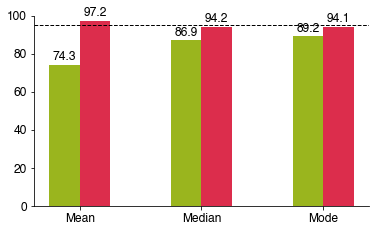

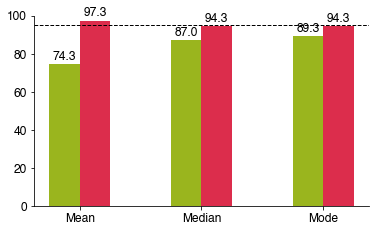

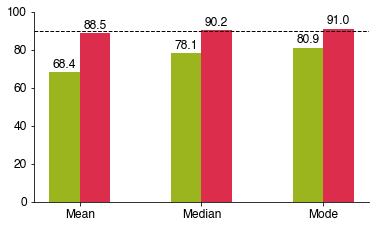

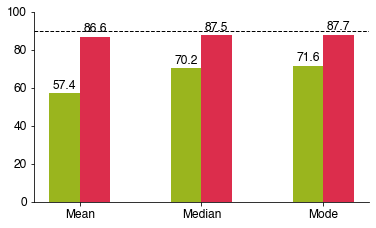

In [28]:
def plot_barchart(readingday,datatype,dataset,n_classifications):

    df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==datatype) &\
                                       (CONSENSUS_SUMMARY.TRUTH_SET==dataset) &\
                                       (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                         (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                         (CONSENSUS_SUMMARY.DRUG=='ALL') &\
                                       (CONSENSUS_SUMMARY.READINGDAY==readingday) &\
                                        (CONSENSUS_SUMMARY.N_CLASSIFICATIONS==n_classifications)] )

    df.rename(columns={'ESSENTIAL_AGREEMENT':'Essential agreement',\
                       'EXACT_AGREEMENT':'Exact agreement',\
                       'METHOD':'Method'},inplace=True)
    df['Method']=df['Method'].str.lower()
    df=df[['Method','Exact agreement','Essential agreement']].groupby('Method').mean()

    fig,axes=plt.subplots(1,1,figsize=(6,3.5))
    x=numpy.arange(3)
    width=0.25
    rects1=axes.bar(x-width/2,df['Exact agreement'],color=bashthebug_colours['green'],width=width)
    rects2=axes.bar(x+width/2,df['Essential agreement'],color=bashthebug_colours['red'],width=width)
    axes.set_xticks(x)
    axes.set_xticklabels(['Mean','Median','Mode'])
    x_range=axes.get_xlim()
    if datatype=='REPRODUCIBILITY':
        axes.plot(x_range,(95,95),'k--',lw=1)
    else:
        axes.plot(x_range,(90,90),'k--',lw=1)
    axes.set_xlim(x_range)
    axes.set_ylim((0,100))
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            axes.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.1f' % height,
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / datatype / dataset / str(n_classifications)                          
    path.mkdir(parents=True,exist_ok=True)

    filename = 'bar-'+str(readingday)+'-'+datatype.lower()+'-'+dataset.lower()+'-'+str(n_classifications)+'.pdf'
    
    fig.savefig(path / filename)
    
    if dataset in ['TRUTH_SET_1','TRUTH_SET_3'] and n_classifications==17:
        pass
    else:
        plt.close()
    
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_3',17)
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_1',17)
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_3',5)
plot_barchart(14,'REPRODUCIBILITY','TRUTH_SET_3',11)

plot_barchart(14,'ACCURACY','TRUTH_SET_3',17)
plot_barchart(14,'ACCURACY','TRUTH_SET_1',17)

# Figure 6, S16

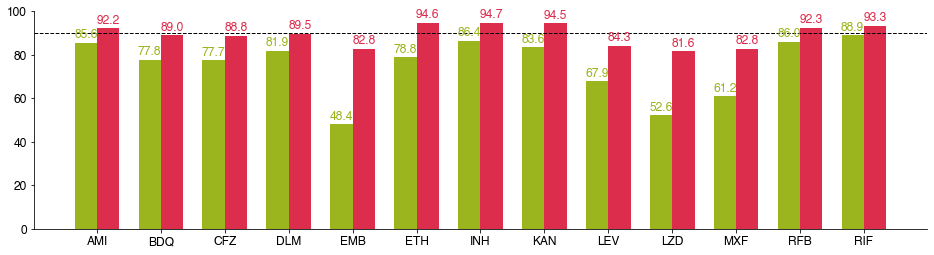

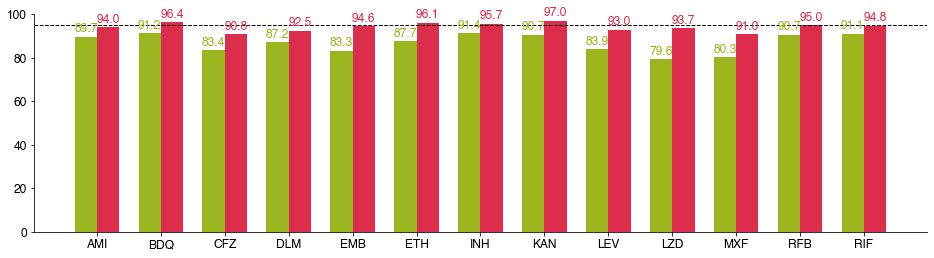

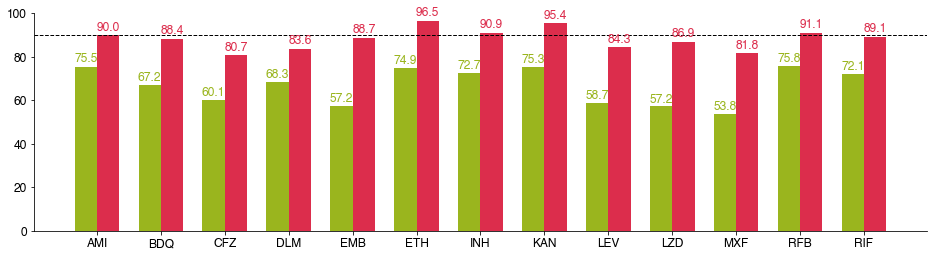

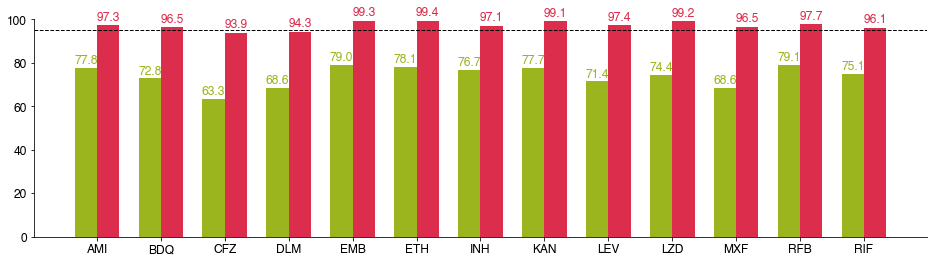

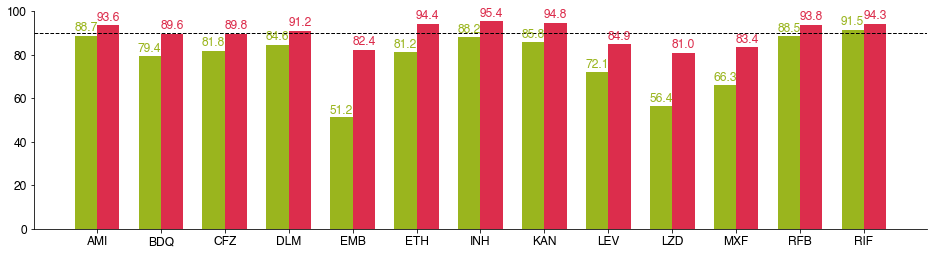

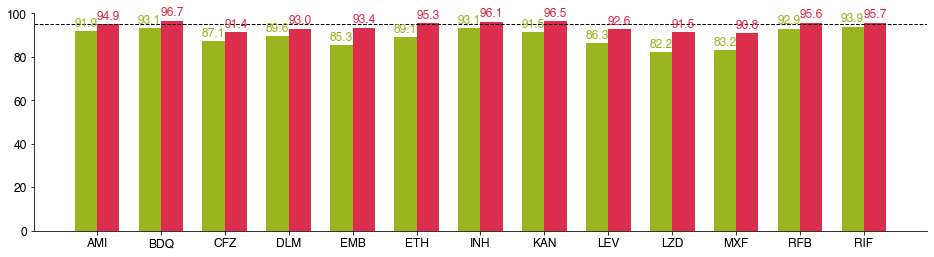

In [29]:
def plot_barchart_drugs(readingday,datatype,dataset,n_classifications,method):

    drugs=list(CONSENSUS_SUMMARY.DRUG.unique())
    if 'ALL' in drugs:
        drugs.remove('ALL')
    if 'PAS' in drugs:
        drugs.remove('PAS')    
    
    df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==datatype) &\
                                           (CONSENSUS_SUMMARY.TRUTH_SET==dataset) &\
                                           (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                           (CONSENSUS_SUMMARY.METHOD==method) &\
                                            (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                            (CONSENSUS_SUMMARY.DRUG.isin(drugs)) &\
                                            (CONSENSUS_SUMMARY.READINGDAY==readingday) &\
                                            (CONSENSUS_SUMMARY.N_CLASSIFICATIONS==n_classifications)] )
    df.rename(columns={'ESSENTIAL_AGREEMENT':'Essential agreement',\
                       'EXACT_AGREEMENT':'Exact agreement',\
                       'DRUG':'Drug'},inplace=True)
    df=df[['Drug','Exact agreement','Essential agreement']].groupby('Drug').mean()

    fig,axes=plt.subplots(1,1,figsize=(16,4))
    x=numpy.arange(len(drugs))
    width=0.35
    rects1=axes.bar(x-width/2,df['Exact agreement'],color=bashthebug_colours['green'],width=width)
    rects2=axes.bar(x+width/2,df['Essential agreement'],color=bashthebug_colours['red'],width=width)
    axes.set_xticks(x)
    axes.set_xticklabels(drugs)
    x_range=axes.get_xlim()
    if datatype=='REPRODUCIBILITY':
        axes.plot(x_range,(95,95),'k--',lw=1)
    else:
        axes.plot(x_range,(90,90),'k--',lw=1)
    axes.set_xlim(x_range)
    axes.set_ylim((0,100))
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

    def autolabel(rects,color):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            axes.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%.1f' % height,
                    ha='center', va='bottom',color=color)

    autolabel(rects1,bashthebug_colours['green'])
    autolabel(rects2,bashthebug_colours['red'])
    
    path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / datatype / dataset / str(n_classifications)                          
    path.mkdir(parents=True,exist_ok=True)

    filename='bar-'+str(readingday)+'-'+datatype.lower()+'-'+dataset.lower()+'-'+str(n_classifications)+'-'+method.lower()+'-drugs.pdf'
    
    fig.savefig(path / filename)
    
    if dataset in ['TRUTH_SET_3'] and n_classifications==17:
        pass
    else:
        plt.close()

plot_barchart_drugs(14,'ACCURACY','TRUTH_SET_3',17,'MEDIAN')
plot_barchart_drugs(14,'REPRODUCIBILITY','TRUTH_SET_3',17,'MEDIAN')

plot_barchart_drugs(14,'ACCURACY','TRUTH_SET_3',17,'MEAN')
plot_barchart_drugs(14,'REPRODUCIBILITY','TRUTH_SET_3',17,'MEAN')

plot_barchart_drugs(14,'ACCURACY','TRUTH_SET_3',17,'MODE')
plot_barchart_drugs(14,'REPRODUCIBILITY','TRUTH_SET_3',17,'MODE')

## Table S5: reproducibility

In [30]:
df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE=='REPRODUCIBILITY') &\
                                       (CONSENSUS_SUMMARY.TRUTH_SET=='TRUTH_SET_3') &\
                                       (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                         (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                         (CONSENSUS_SUMMARY.DRUG=='ALL') &\
                                        (CONSENSUS_SUMMARY.N_CLASSIFICATIONS<=17)] )

df.replace({'METHOD':{'MEDIAN':'Median','MEAN':'Mean','MODE':'Mode'}},inplace=True)
df.rename(columns={'N_CLASSIFICATIONS':'Number of classifications'},inplace=True)


pivot=df.pivot(index=['Number of classifications','READINGDAY','BOOTSTRAP_RUN'],\
            columns='METHOD',\
            values=['INNER_SQUARE','EXACT_AGREEMENT','ESSENTIAL_AGREEMENT'])
pivot.reset_index(inplace=True)

table=pivot[[('Number of classifications',''),('READINGDAY',''),('INNER_SQUARE','Mean'),('EXACT_AGREEMENT','Mean'),\
                             ('EXACT_AGREEMENT','Median'),\
                             ('EXACT_AGREEMENT','Mode'),\
                             ('ESSENTIAL_AGREEMENT','Mean'),\
                             ('ESSENTIAL_AGREEMENT','Median'),\
                             ('ESSENTIAL_AGREEMENT','Mode')]]\
.groupby([('READINGDAY',''),('Number of classifications','')]).agg([numpy.mean,stats.sem])    

def return_formatted_values(row):
    tmp=[]
    tmp.append("%.1f $\pm$ %.1f "% (row[('INNER_SQUARE','Mean','mean')],row[('INNER_SQUARE','Mean','sem')]))
    for j in ['EXACT_AGREEMENT','ESSENTIAL_AGREEMENT']:
        for i in ['Mean','Median','Mode']:
            tmp.append("%.1f $\pm$ %.1f "% (row[(j,i,'mean')],row[(j,i,'sem')]))
    return(pandas.Series(tmp))

table=copy.deepcopy(table.apply(return_formatted_values,axis=1))
table.index.names=['Reading day','$n$']
tuples=[('Prop. with','MIC (\%)'),('Exact Agreement (\%)','Mean'),('Exact Agreement (\%)','Median'),('Exact Agreement (\%)','Mode'),('Essential Agreement (\%)','Mean'),('Essential Agreement (\%)','Median'),('Essential Agreement (\%)','Mode')]
table.columns=pandas.MultiIndex.from_tuples(tuples)


print("\\begin{table}\n\\begin{center}")
print(table.to_latex(index=True,\
                     escape=False,\
                     column_format='rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}',\
                     multicolumn_format='c',\
                     multirow=True).rstrip())
print("\\caption[The effect on reproducibility of varying the number of days incubated, the number of classifications and the consensus method.]{\\label{table:S4} The effect on reproducibility of varying the number of days incubated, the number of classifications, $n$, and the consensus method. The standard error of the mean is given.}")
print("\\end{center}\n\\end{table}\n")


\begin{table}
\begin{center}
\begin{tabular}{rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}}
\toprule
   &    &       Prop. with & \multicolumn{3}{c}{Exact Agreement (\%)} & \multicolumn{3}{c}{Essential Agreement (\%)} \\
   &    &         MIC (\%) &                 Mean &           Median &             Mode &                     Mean &           Median &             Mode \\
Reading day & $n$ &                  &                      &                  &                  &                          &                  &                  \\
\midrule
\multirow{9}{*}{7} & 1  &  62.6 $\pm$ 0.1  &      68.6 $\pm$ 0.1  &  68.6 $\pm$ 0.1  &  68.6 $\pm$ 0.1  &          82.6 $\pm$ 0.1  &  82.6 $\pm$ 0.1  &  82.6 $\pm$ 0.1  \\
   & 3  &  69.3 $\pm$ 0.1  &      61.7 $\pm$ 0.1  &  71.6 $\pm$ 0.1  &  75.2 $\pm$ 0.1  &          84.3 $\pm$ 0.1  &  86.0 $\pm$ 0.1  &  86.9 $\pm$ 0.1  \\
   & 5  &  71.8 $\pm$ 0.1  &      63.3 $\pm$ 0.1  &  76.9 $\pm$ 0.1  &  79.4 $\pm$ 0.1  &          89.5 

# Table S6: accuracy

In [31]:
df=copy.deepcopy(CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE=='ACCURACY') &\
                                       (CONSENSUS_SUMMARY.TRUTH_SET=='TRUTH_SET_3') &\
                                       (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                       (CONSENSUS_SUMMARY.GROWTH=='ALL') &\
                                       (CONSENSUS_SUMMARY.DRUG=='ALL') &\
                                       (CONSENSUS_SUMMARY.N_CLASSIFICATIONS<=17) &\
                                       (CONSENSUS_SUMMARY.N_CLASSIFICATIONS>1) ])

df.replace({'METHOD':{'MEDIAN':'Median','MEAN':'Mean','MODE':'Mode'}},inplace=True)
df.rename(columns={'N_CLASSIFICATIONS':'Number of classifications'},inplace=True)


pivot=df.pivot(index=['Number of classifications','READINGDAY','BOOTSTRAP_RUN'],\
            columns='METHOD',\
            values=['PROP_READ','EXACT_AGREEMENT','ESSENTIAL_AGREEMENT'])
pivot.reset_index(inplace=True)

table=pivot[[('Number of classifications',''),('READINGDAY',''),('PROP_READ','Mean'),('EXACT_AGREEMENT','Mean'),\
                             ('EXACT_AGREEMENT','Median'),\
                             ('EXACT_AGREEMENT','Mode'),\
                             ('ESSENTIAL_AGREEMENT','Mean'),\
                             ('ESSENTIAL_AGREEMENT','Median'),\
                             ('ESSENTIAL_AGREEMENT','Mode')]]\
.groupby([('READINGDAY',''),('Number of classifications','')]).agg([numpy.mean,stats.sem])    

def return_formatted_values(row):
    tmp=[]
    tmp.append("%.1f $\pm$ %.1f "% (row[('PROP_READ','Mean','mean')],row[('PROP_READ','Mean','sem')]))
    for j in ['EXACT_AGREEMENT','ESSENTIAL_AGREEMENT']:
        for i in ['Mean','Median','Mode']:
            tmp.append("%.1f $\pm$ %.1f "% (row[(j,i,'mean')],row[(j,i,'sem')]))
    return(pandas.Series(tmp))

table=copy.deepcopy(table.apply(return_formatted_values,axis=1))
table.index.names=['Reading day','$n$']
tuples=[('Prop. with','MIC (\%)'),('Exact Agreement (\%)','Mean'),('Exact Agreement (\%)','Median'),('Exact Agreement (\%)','Mode'),('Essential Agreement (\%)','Mean'),('Essential Agreement (\%)','Median'),('Essential Agreement (\%)','Mode')]
table.columns=pandas.MultiIndex.from_tuples(tuples)

print("\\begin{table}\n\\begin{center}")
print(table.to_latex(index=True,\
                     escape=False,\
                     column_format='rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}',\
                     multicolumn_format='c',\
                     multirow=True).rstrip())
print("\\caption[The effect on accuracy of varying the number of days incubated, the number of classifications and the consensus method.]{\\label{table:S4} The effect on accuracy of varying the number of days incubated, the number of classifications, $n$, and the consensus method. The standard error of the mean is given.}")
print("\\end{center}\n\\end{table}\n")


\begin{table}
\begin{center}
\begin{tabular}{rr|p{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}}
\toprule
   &    &       Prop. with & \multicolumn{3}{c}{Exact Agreement (\%)} & \multicolumn{3}{c}{Essential Agreement (\%)} \\
   &    &         MIC (\%) &                 Mean &           Median &             Mode &                     Mean &           Median &             Mode \\
Reading day & $n$ &                  &                      &                  &                  &                          &                  &                  \\
\midrule
\multirow{8}{*}{7} & 3  &  78.0 $\pm$ 0.1  &      67.6 $\pm$ 0.2  &  69.1 $\pm$ 0.2  &  74.0 $\pm$ 0.2  &          84.0 $\pm$ 0.1  &  85.8 $\pm$ 0.1  &  89.4 $\pm$ 0.1  \\
   & 5  &  78.5 $\pm$ 0.1  &      67.3 $\pm$ 0.1  &  70.1 $\pm$ 0.1  &  73.5 $\pm$ 0.1  &          86.5 $\pm$ 0.1  &  87.3 $\pm$ 0.1  &  89.2 $\pm$ 0.1  \\
   & 7  &  78.9 $\pm$ 0.1  &      67.9 $\pm$ 0.2  &  70.3 $\pm$ 0.1  &  73.7 $\pm$ 0.1  &          87.4 

# Table S7, S8: Does halting at n=3 improve matters?

In [32]:
def return_weighted_value(a,b,column):
    a_x=float(a[column])
    b_x=float(b[column])
    a_n=float(a['N'])
    b_n=float(b['N'])
    value=(((a_x*a_n)+(b_x*b_n))/(a_n+b_n))
    return(value)


for metric in ['REPRODUCIBILITY','ACCURACY']:

    table=[]

    for reading_day in [14]:

        df=CONDENSED_SUMMARY.loc[ (CONDENSED_SUMMARY.READINGDAY==reading_day) &\
                                  (CONDENSED_SUMMARY.GROWTH=='ALL') &\
                                  (CONDENSED_SUMMARY.DRUG=='ALL') &\
                                  (CONDENSED_SUMMARY.TRUTH_SET=='TRUTH_SET_3') &\
                                  (CONDENSED_SUMMARY.TYPE==metric)  ]

        zero_rows=copy.deepcopy(df.loc[(df.N_CLASSIFICATIONS==3) & (df.STDDEV=='ZERO')])

        for n in [3,5,7,9,11,13,15,17]:

            line=[]
            line.append(reading_day)

            non_zero_rows=df.loc[(df.N_CLASSIFICATIONS==n) & (df.STDDEV=='NOT_ZERO')]

            line.append(n)

            for method in ['MEAN','MEDIAN','MODE']:

                a=zero_rows.loc[zero_rows.METHOD==method]       
                b=non_zero_rows.loc[non_zero_rows.METHOD==method]

                if method=='MEAN':
                    line.append(return_weighted_value(a,b,'N_CLASSIFICATIONS'))

                    line.append(return_weighted_value(a,b,'PROP_READ'))

                diagonal=return_weighted_value(a,b,'DIAGONAL')
                inner_square=return_weighted_value(a,b,'INNER_SQUARE')

                line.append(100*diagonal/inner_square)

            for method in ['MEAN','MEDIAN','MODE']:

                a=zero_rows.loc[zero_rows.METHOD==method]       
                b=non_zero_rows.loc[non_zero_rows.METHOD==method]

                diagonal=return_weighted_value(a,b,'DIAGONAL')
                inner_square=return_weighted_value(a,b,'INNER_SQUARE')
                upper_diagonal=return_weighted_value(a,b,'UPPER_DIAGONAL')
                lower_diagonal=return_weighted_value(a,b,'LOWER_DIAGONAL')        

                line.append(100*(upper_diagonal+diagonal+lower_diagonal)/inner_square)

            table.append(line)

    table=pandas.DataFrame(table,columns=['Reading day','$n$','av N','prop','X1','X2','X3','M1','M2','M3'])

    table.set_index(['Reading day','$n$'],inplace=True)

    table.columns=pandas.MultiIndex.from_tuples([('Average','$n$'),('Prop. with','MIC (\%)'),('Exact Agreement (\%)','Mean'),('Exact Agreement (\%)','Median'),('Exact Agreement (\%)','Mode'),('Essential Agreement (\%)','Mean'),('Essential Agreement (\%)','Median'),('Essential Agreement (\%)','Mode')])

    print("\\begin{table}\n\\begin{center}")
    print(table.to_latex(index=True,\
                        float_format='%.1f',\
                         escape=False,\
                         column_format='rr|rp{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}',\
                         multicolumn_format='c',\
                         multirow=True).rstrip() )
    
    if metric=='REPRODUCIBILITY':
        print("\\caption[Reproducibility when applying early halting]{\\label{table:S7} The effect on reproducibility of dynamically retiring images if the first three classifications are identical and continuing the remainder until they have accrued $n$ classifications.}") 
    else:
        print("\\caption[Accuracy when applying early halting]{\\label{table:S8} The effect on accuracy of dynamically retiring images if the first three classifications are identical and continuing the remainder until they have accrued $n$ classifications.}") 
    print("\\end{center}\n\\end{table}\n")


\begin{table}
\begin{center}
\begin{tabular}{rr|rp{1.8cm}|p{1.6cm}p{1.6cm}p{1.6cm}|p{1.6cm}p{1.6cm}p{1.6cm}}
\toprule
   &    & Average & Prop. with & \multicolumn{3}{c}{Exact Agreement (\%)} & \multicolumn{3}{c}{Essential Agreement (\%)} \\
   &    &     $n$ &   MIC (\%) &                 Mean & Median & Mode &                     Mean & Median & Mode \\
Reading day & $n$ &         &            &                      &        &      &                          &        &      \\
\midrule
\multirow{8}{*}{14} & 3  &     3.0 &       95.1 &                 81.4 &   79.1 & 81.7 &                     92.6 &   89.3 & 90.4 \\
   & 5  &     3.9 &       96.6 &                 79.0 &   82.7 & 84.4 &                     93.1 &   91.4 & 91.6 \\
   & 7  &     4.7 &       97.1 &                 80.0 &   83.6 & 85.7 &                     94.4 &   92.1 & 92.1 \\
   & 9  &     5.6 &       97.4 &                 80.8 &   84.6 & 86.6 &                     95.3 &   92.8 & 92.7 \\
   & 11 &     6.5 &       

# Table S9: Agreement between Expert and BashTheBug by dilution

In [33]:
if running_using_binder:

    print("Sorry but the table required to plot this figure uses too much memory for mybinder; please clone the repository and run the juypter-notebook locally")

else:

    BOOTSTRAPPED_CLASSIFICATIONS.reset_index(inplace=True)
    
    df=BOOTSTRAPPED_CLASSIFICATIONS.loc[ (BOOTSTRAPPED_CLASSIFICATIONS.READINGDAY==14)]

    df['MEDIAN_XA']=(df['MEDIAN']==df['TRUTH_SET_1'])
    df['MEDIAN_CEIL']=numpy.ceil(df['MEDIAN'])

    df['MEDIAN_EA']=(df.MEDIAN_CEIL<=df['TRUTH_SET_1']+1) & (df.MEDIAN_CEIL>=df['TRUTH_SET_1']-1)

    table=copy.deepcopy(df[['MEDIAN_CEIL','MEDIAN_XA']].groupby('MEDIAN_CEIL').agg([numpy.mean,stats.sem]))
    table.columns=table.columns.droplevel()

    def return_formatted_values(row):
        return("%.1f $\pm$ %.1f %%"% (100*row[('mean')],100*row[('sem')]))
    table['Agreement']=table.apply(return_formatted_values,axis=1)

    table.reset_index(inplace=True)
    table.rename(columns={'MEDIAN_CEIL':'Dilution'},inplace=True)
    table.Dilution=table.Dilution.astype(int)
    table.replace({'Dilution':{0:'NR'}},inplace=True)
    table=table[['Dilution','Agreement']]

    print("\\begin{table}\n\\begin{center}")
    print(table.to_latex(float_format='%.1f %',\
                         column_format='r|r',\
                   escape=False,\
                   index=False).rstrip())
    print("\\caption[The Expert and BashTheBug MICs are more likely to concur at smaller dilutions. ]{\\label{table:S4} The Expert and BashTheBug MICs are more likely to concur at smaller dilutions. The BashTheBug consensus measurement was built by taking the median of 17 classifications and rounding up if a non-integer was returned. The standard error of the mean is given.}")
    print("\\end{center}\n\\end{table}\n")
    
    BOOTSTRAPPED_CLASSIFICATIONS.set_index(['PLATE','READINGDAY'],inplace=True)

/var/folders/np/2z_qny9911n2mqth2n63j9y80009px/T/ipykernel_22513/3453454596.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MEDIAN_XA']=(df['MEDIAN']==df['TRUTH_SET_1'])
/var/folders/np/2z_qny9911n2mqth2n63j9y80009px/T/ipykernel_22513/3453454596.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MEDIAN_CEIL']=numpy.ceil(df['MEDIAN'])
/var/folders/np/2z_qny9911n2mqth2n63j9y80009px/T/ipykernel_22513/3453454596.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

\begin{table}
\begin{center}
\begin{tabular}{r|r}
\toprule
Dilution &        Agreement \\
\midrule
      NR & 20.0 $\pm$ 0.1 % \\
       1 & 83.9 $\pm$ 0.1 % \\
       2 & 72.0 $\pm$ 0.1 % \\
       3 & 66.6 $\pm$ 0.1 % \\
       4 & 48.2 $\pm$ 0.1 % \\
       5 & 53.4 $\pm$ 0.1 % \\
       6 & 52.6 $\pm$ 0.1 % \\
       7 & 42.8 $\pm$ 0.1 % \\
       8 & 46.7 $\pm$ 0.1 % \\
       9 & 21.1 $\pm$ 0.2 % \\
\bottomrule
\end{tabular}
\caption[The Expert and BashTheBug MICs are more likely to concur at smaller dilutions. ]{\label{table:S4} The Expert and BashTheBug MICs are more likely to concur at smaller dilutions. The BashTheBug consensus measurement was built by taking the median of 17 classifications and rounding up if a non-integer was returned. The standard error of the mean is given.}
\end{center}
\end{table}



## Fig 5, S11, S12, S13, S14, S15. Combined graphs (incl. growth)

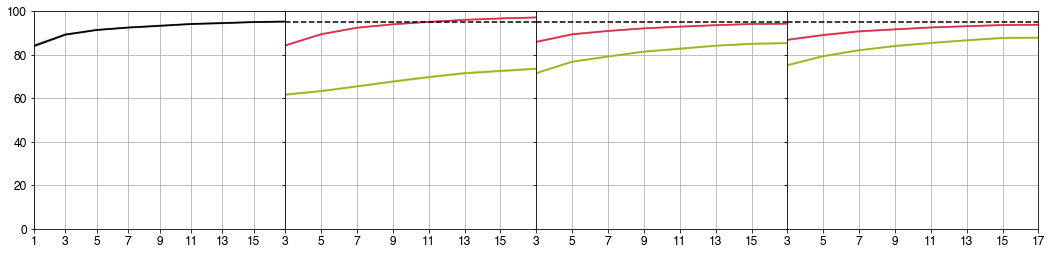

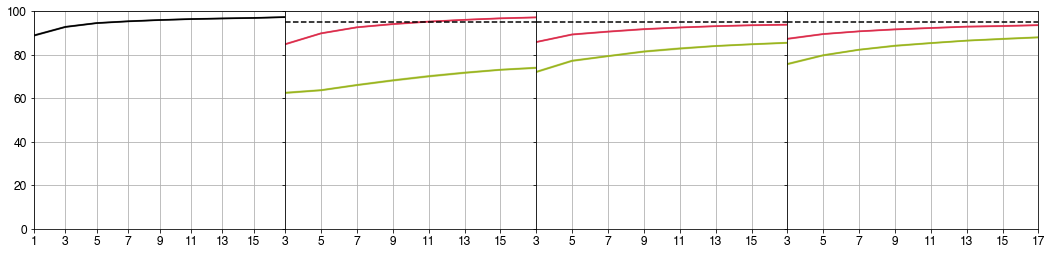

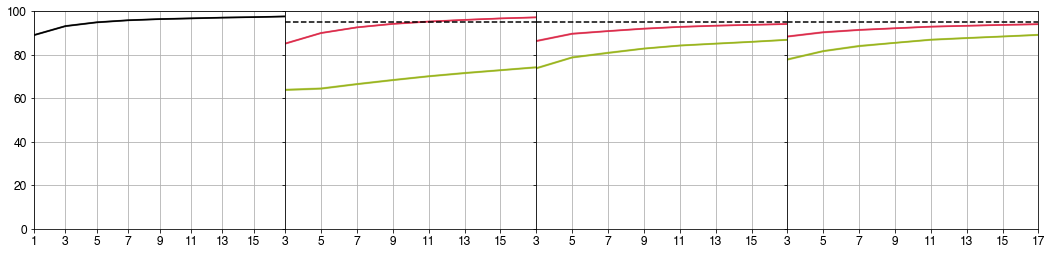

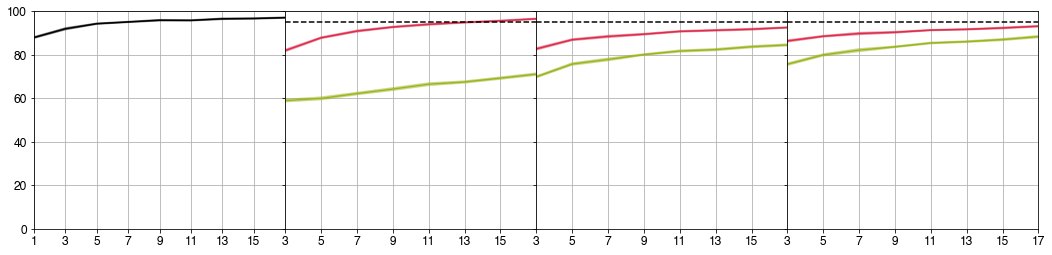

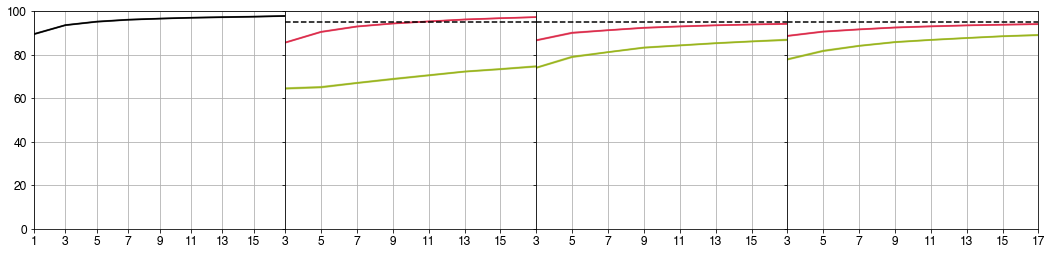

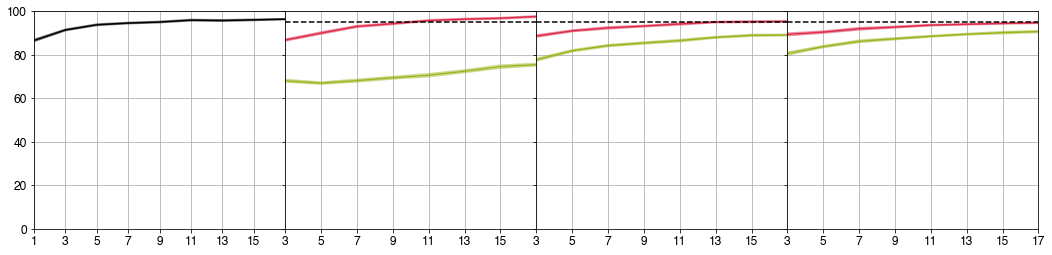

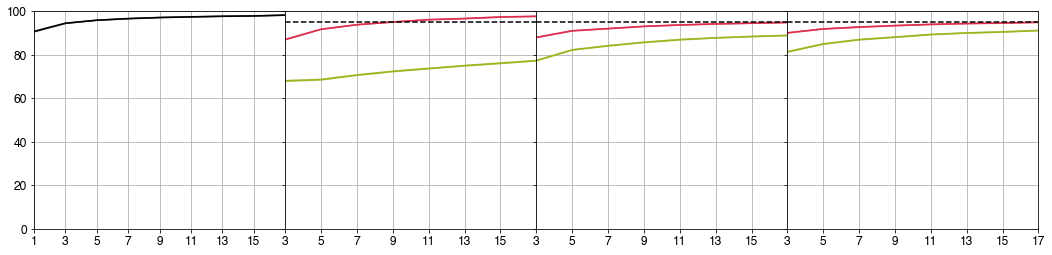

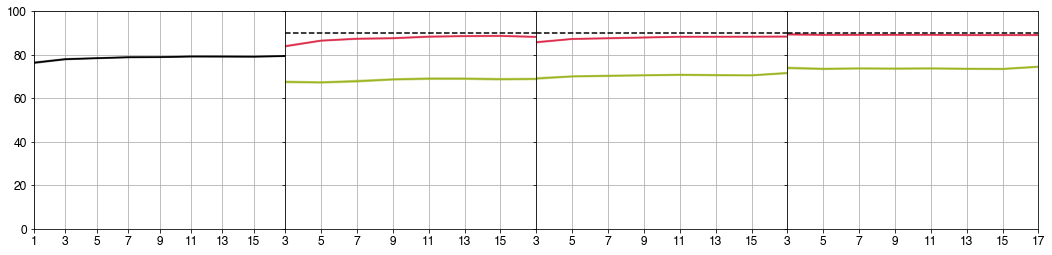

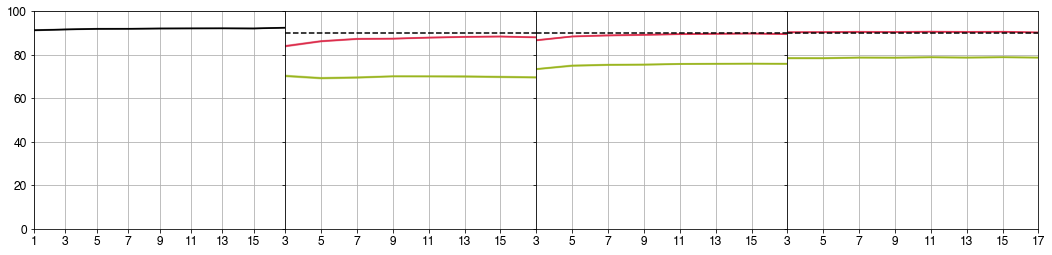

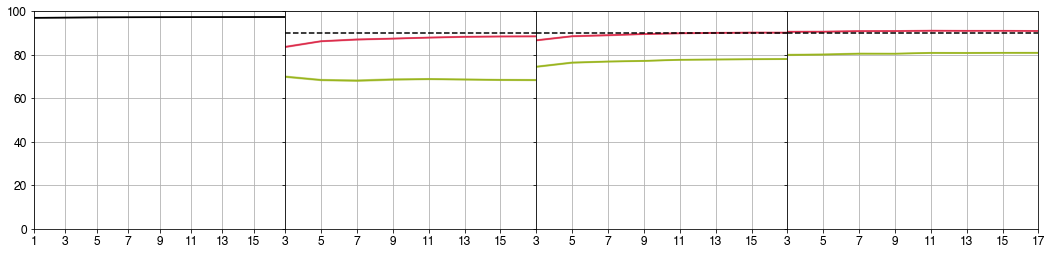

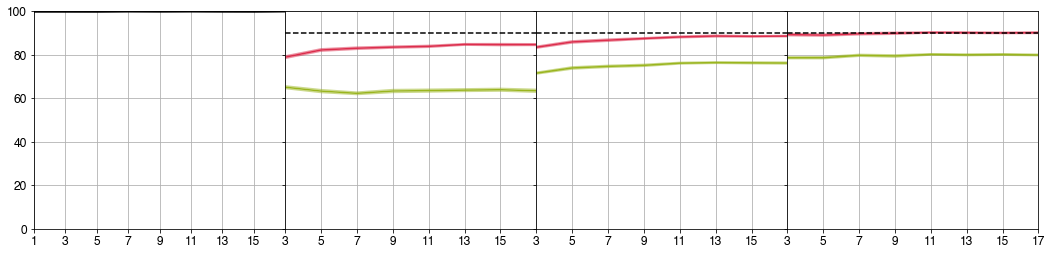

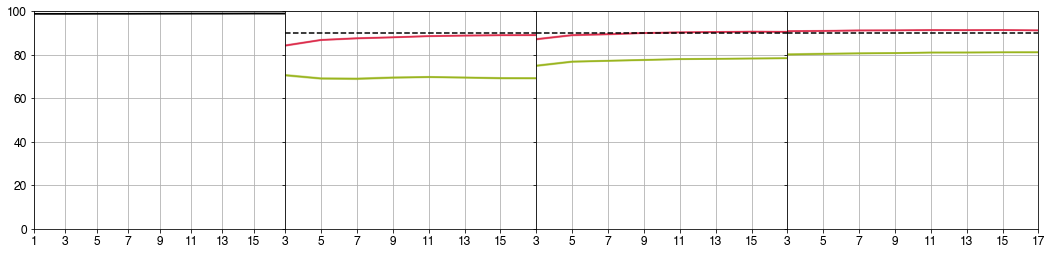

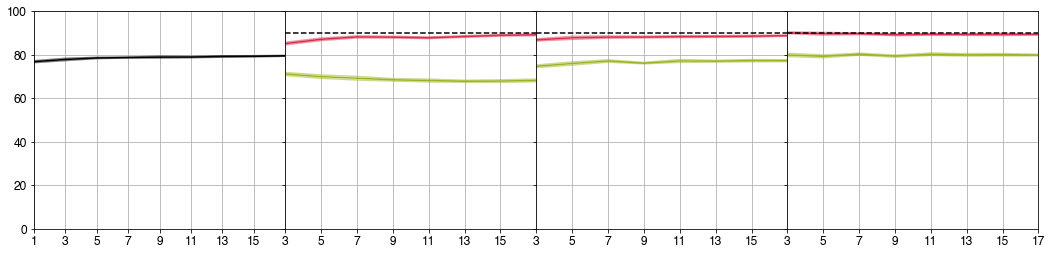

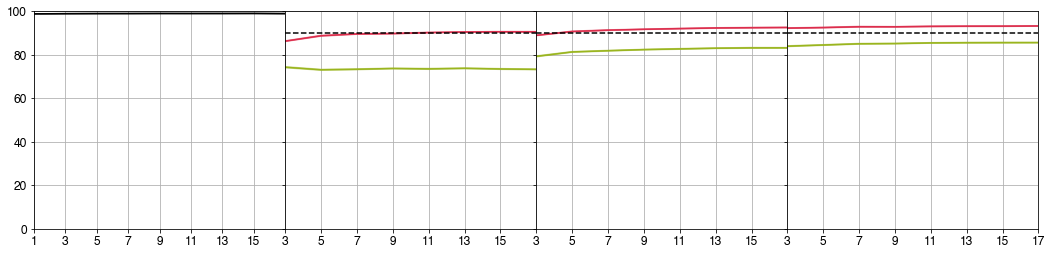

In [34]:
methods=['mean','median','mode']

for dataset_type in ['reproducibility','accuracy']:

    for truth_set in ['truth_set_3']:

        for reading_day in [7,10,14,21]:

            for growth in ['ALL','HIGH','MEDIUM','LOW']:

                if reading_day!=14 and growth!='ALL':
                    continue 
                                 
                fig,axes=plt.subplots(1,4,figsize=(18,4),sharey=True)
                
                fig.subplots_adjust(wspace=0)

                # subset out the rows we want
                df2=CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==dataset_type.upper()) &\
                                         (CONSENSUS_SUMMARY.TRUTH_SET==truth_set.upper()) &\
                                         (CONSENSUS_SUMMARY.METHOD=='MEAN') &\
                                         (CONSENSUS_SUMMARY.READINGDAY==reading_day) &\
                                         (CONSENSUS_SUMMARY.GROWTH==growth) &\
                                         (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                         (CONSENSUS_SUMMARY.DRUG=='ALL')]
                if not df2.empty:
                    # aggregate over the bootstrapped runs
                    df=df2[['N_CLASSIFICATIONS','PROP_READ']].groupby(['N_CLASSIFICATIONS']).agg([numpy.mean,stats.sem])                
                    axes[0].plot(df[('PROP_READ','mean')],color='black')
                    axes[0].plot(df[('PROP_READ','mean')]+1.96*df['PROP_READ','sem'],color='black',alpha=0.5)
                    axes[0].plot(df[('PROP_READ','mean')]-1.96*df['PROP_READ','sem'],color='black',alpha=0.5)
                    axes[0].set_ylim([0,100])
                    axes[0].set_xlim([3,17])
                    axes[0].set_xticks(df.index[:-3])
                    axes[0].grid()
                    
                for i in [1,2,3]:

                    # subset out the rows we want
                    df2=CONSENSUS_SUMMARY.loc[(CONSENSUS_SUMMARY.TYPE==dataset_type.upper()) &\
                                             (CONSENSUS_SUMMARY.TRUTH_SET==truth_set.upper()) &\
                                             (CONSENSUS_SUMMARY.METHOD==methods[i-1].upper()) &\
                                             (CONSENSUS_SUMMARY.READINGDAY==reading_day) &\
                                             (CONSENSUS_SUMMARY.GROWTH==growth) &\
                                             (CONSENSUS_SUMMARY.STDDEV=='ALL') &\
                                             (CONSENSUS_SUMMARY.DRUG=='ALL')]
                    if not df2.empty:

                        # aggregate over the bootstrapped runs
                        df=df2[['N_CLASSIFICATIONS','ESSENTIAL_AGREEMENT','EXACT_AGREEMENT']].groupby(['N_CLASSIFICATIONS']).agg([numpy.mean,stats.sem])

                        axes[i].plot(df[('ESSENTIAL_AGREEMENT','mean')],color=bashthebug_colours['red'])
                        axes[i].plot(df[('ESSENTIAL_AGREEMENT','mean')]+1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                        axes[i].plot(df[('ESSENTIAL_AGREEMENT','mean')]-1.96*df['ESSENTIAL_AGREEMENT','sem'],color=bashthebug_colours['red'],alpha=0.5)
                        axes[i].plot(df[('EXACT_AGREEMENT','mean')],color=bashthebug_colours['green'])
                        axes[i].plot(df[('EXACT_AGREEMENT','mean')]+1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                        axes[i].plot(df[('EXACT_AGREEMENT','mean')]-1.96*df['EXACT_AGREEMENT','sem'],color=bashthebug_colours['green'],alpha=0.5)
                        axes[i].set_ylim([0,100])
                        if i==3:
                            axes[i].set_xticks(df.index[:-2])
                        else:
                            axes[i].set_xticks(df.index[:-3])

                        axes[i].grid()
                        if dataset_type=='reproducibility':
                            axes[i].plot((3,17),(95,95),color='black',linestyle='--')                
                        else:
                            axes[i].plot((3,17),(90,90),color='black',linestyle='--')

                        axes[i].set_xlim([3,17])
                        
                if growth=='ALL':
                    path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / dataset_type / truth_set /  'all' 
                else:
                    path=pathlib.Path.cwd() / 'pdf' / str(reading_day) / dataset_type / truth_set /  'all' / growth.lower()

                path.mkdir(parents=True,exist_ok=True)
                filename = 'summary-'+str(reading_day)+'-'+dataset_type+'-'+truth_set+'-growth-'+growth.lower()+'-combined.pdf'                    

                fig.savefig(path / filename ,bbox_inches=0)

                if growth=='ALL':
                    pass
                elif reading_day==14:
                    pass     
                else:
                    plt.close()

